# Understanding the stability of MPFs

Over in the guide [How to choose the Trotter steps for an MPF](https://qiskit.github.io/qiskit-addon-mpf/how_tos/choose_trotter_steps.html) we introduced a heuristic that limits the **smallest** $k_j$ value ($k_{\text{min}}$) based on the total evolution time, $t$, that we would like to reach.
In particular, we state that $t/k_{\text{min}} \lt 1$ must be satisfied (noting that $t/k_{\text{min}} \leq 1$ empirically seems to work fine, too).

On this page, we will analyze the behavior of MPFs is not guaranteed to work well, when this constraint gets violated.

## Setting up a simple model problem

For this simple example, we will reuse the model problem from the [Getting started](https://qiskit.github.io/qiskit-addon-mpf/tutorials/01_getting_started.html) tutorial; the Ising model on a line of 10 sites:

$$
\hat{\mathcal{H}}_{\text{Ising}} = \sum_{i=1}^{9} J_{i,(i+1)} Z_i Z_{(i+1)} + \sum_{i=1}^{10} h_i X_i \, ,
$$

where $J$ is the coupling strength between two sites and $h$ is the external magnetic field.

In [1]:
from qiskit.transpiler import CouplingMap
from qiskit_addon_utils.problem_generators import generate_xyz_hamiltonian

coupling_map = CouplingMap.from_line(10, bidirectional=False)

hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants=(0.0, 0.0, 1.0),
    ext_magnetic_field=(0.4, 0.0, 0.0),
)
print(hamiltonian)

SparsePauliOp(['IIIIIIIZZI', 'IIIIIZZIII', 'IIIZZIIIII', 'IZZIIIIIII', 'IIIIIIIIZZ', 'IIIIIIZZII', 'IIIIZZIIII', 'IIZZIIIIII', 'ZZIIIIIIII', 'IIIIIIIIIX', 'IIIIIIIIXI', 'IIIIIIIXII', 'IIIIIIXIII', 'IIIIIXIIII', 'IIIIXIIIII', 'IIIXIIIIII', 'IIXIIIIIII', 'IXIIIIIIII', 'XIIIIIIIII'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j,
 1. +0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j, 0.4+0.j,
 0.4+0.j, 0.4+0.j, 0.4+0.j])


The observable that we will be measuring is the total magnetization which we can simply construct as shown below:

In [2]:
from qiskit.quantum_info import SparsePauliOp

L = coupling_map.size()
observable = SparsePauliOp.from_sparse_list([("Z", [i], 1 / L / 2) for i in range(L)], num_qubits=L)
print(observable)

SparsePauliOp(['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIIZIIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII'],
              coeffs=[0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j, 0.05+0.j,
 0.05+0.j, 0.05+0.j, 0.05+0.j])


## Simulating various Trotter circuits

Our analysis simply consists of comparing the behavior of product formulas of various order (here, second and fourth order) to the exact solution (which we can compute for a problem as simple as this one).

In the code cell below, we do exactly that, for evolution times ranging from $2$ up to $10$ and Trotter steps ranging from $1$ to $25$.

In [3]:
import numpy as np
from qiskit.primitives import StatevectorEstimator
from qiskit.synthesis import SuzukiTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit
from scipy.linalg import expm

estimator = StatevectorEstimator()
times = np.array(range(2, 11))
ks = np.array(range(1, 25))

exact = []
order2 = []
order4 = []

for time in times:
    exp_H = expm(-1j * time * hamiltonian.to_matrix())
    initial_state = np.zeros(exp_H.shape[0])
    initial_state[0] = 1.0
    time_evolved_state = exp_H @ initial_state
    exact_evs = time_evolved_state.conj() @ observable.to_matrix() @ time_evolved_state
    exact.append(float(exact_evs))

    for k in ks:
        order2_circ = generate_time_evolution_circuit(
            hamiltonian, synthesis=SuzukiTrotter(reps=k, order=2), time=time
        )
        order4_circ = generate_time_evolution_circuit(
            hamiltonian, synthesis=SuzukiTrotter(reps=k, order=4), time=time
        )

        job = estimator.run([(order2_circ, observable), (order4_circ, observable)])
        result = job.result()
        order2.append(result[0].data.evs)
        order4.append(result[1].data.evs)

## Analyzing the results

We can now analyze the computed results by plotting them.

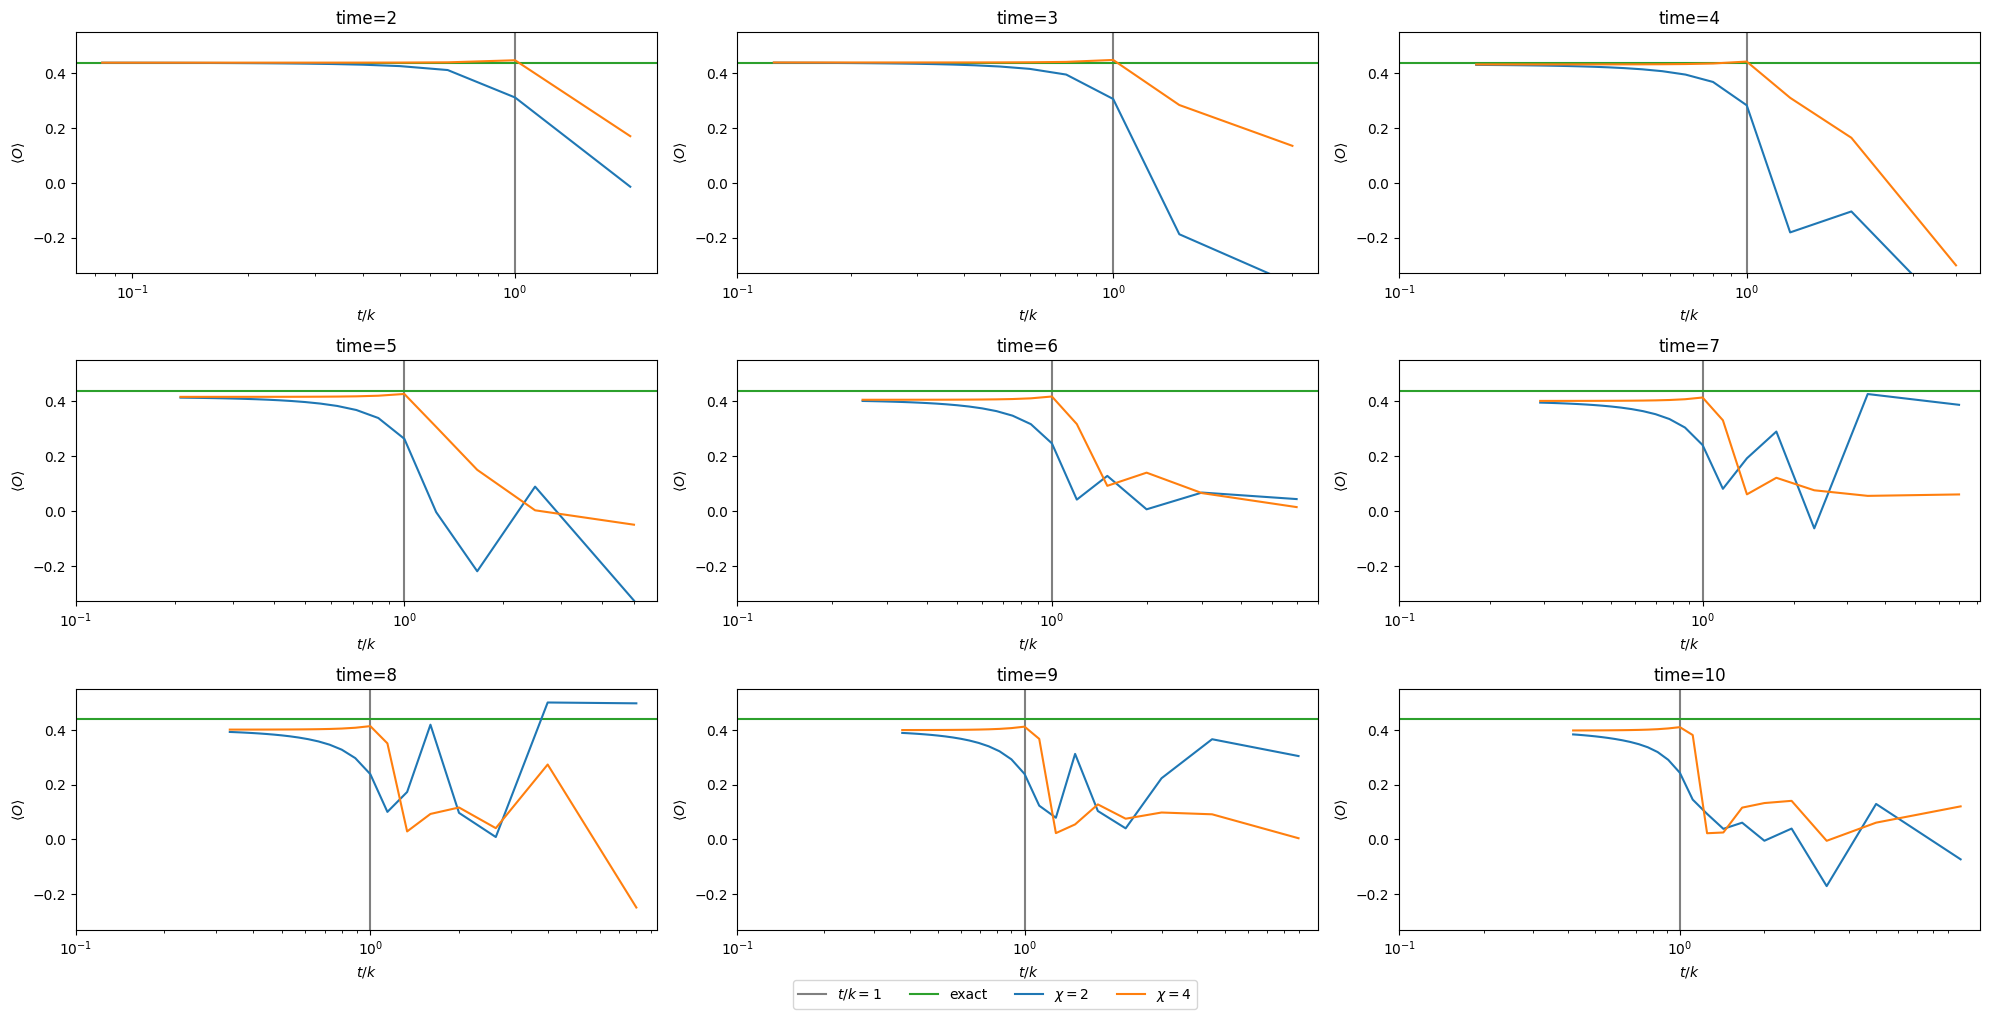

In [4]:
from matplotlib import pyplot as plt

order2_reshaped = np.asarray(order2).reshape((len(times), len(ks)))
order4_reshaped = np.asarray(order4).reshape((len(times), len(ks)))

fig, axes = plt.subplots(3, 3, figsize=(20, 10))

for i, t in enumerate(times):
    ax = axes[i // 3, i % 3]

    ax.axvline(1.0, color="grey", label="$t/k=1$")
    ax.axhline(exact[i], color="tab:green", label="exact")

    ax.plot(t / ks, order2_reshaped[i], label=r"$\chi=2$")
    ax.plot(t / ks, order4_reshaped[i], label=r"$\chi=4$")

    ax.semilogx()
    ax.set_xticks([10**p for p in range(-1, 1)])
    ax.set_xlabel("$t/k$")

    ax.set_ylim([-0.33, 0.55])
    ax.set_ylabel(r"$\langle O \rangle$")

    ax.set_title(f"time={t}")

fig.legend(*ax.get_legend_handles_labels(), ncols=4, loc="center", bbox_to_anchor=(0.5, 0.0))
fig.tight_layout()

We can now clearly see that in the regime $t/k \gt 1$ the dynamics are no longer reproduced faithfully by the Trotterized circuits. Thus, if an MPF were to use a product formula with a $k_j$ from that regime, its extrapolated expectation value cannot faithfully produce good results.